In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 40 # 40 min

## Laden der Produktionsaufträge

In [4]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [5]:
file = file_template.format(text= "all_job_times")

df_job_times_all = pd.read_csv(data_path / file)
df_job_times_all['Job'] = df_job_times_all['Job'].astype(str)
df_job_times_all

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
...,...,...,...,...,...,...,...
415,415,6,28598,30681,28800,416,1465
416,416,4,28606,30573,28800,393,1380
417,417,5,28722,31205,28800,496,1909
418,418,7,28746,31444,28800,539,2105


In [6]:
file = file_template.format(text= "all_jssp")
df_jssp_all = pd.read_csv(data_path / file)
df_jssp_all['Job'] = df_jssp_all['Job'].astype(str)
df_jssp_all

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
4195,419,8,5,M09,11
4196,419,8,6,M06,40
4197,419,8,7,M07,89
4198,419,8,8,M04,26


## Laden der Initialisierungsdaten vom Tag 1

In [7]:
day_numb = 1

In [8]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
df_schedule = pd.read_csv(data_path / file)
df_schedule 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,3,3,0,M01,236,2443,1440,81,1521,-922,0,922
1,12,8,0,M00,992,2959,1440,76,1516,-1443,0,1443
2,15,7,0,M02,1193,3397,1440,31,1471,-1926,0,1926
3,5,5,0,M02,485,3488,1471,84,1555,-1933,0,1933
4,1,1,0,M00,136,2999,1516,43,1559,-1440,0,1440
...,...,...,...,...,...,...,...,...,...,...,...,...
175,4,4,9,M06,404,3814,3761,53,3814,0,0,0
176,0,0,9,M09,51,3806,3785,21,3806,0,0,0
177,17,3,9,M05,1343,4017,3974,43,4017,0,0,0
178,14,4,9,M06,1177,4658,4605,53,4658,0,0,0


In [9]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,0,0,0,M00,51,2035.82,14.88,2050.70
1,0,0,1,M01,51,2330.98,92.29,2423.27
2,0,0,2,M02,51,2423.27,10.50,2433.77
3,0,0,3,M03,51,2621.00,35.42,2656.42
4,0,0,4,M04,51,2748.11,60.73,2808.84
...,...,...,...,...,...,...,...,...
145,17,3,4,M06,1343,2563.00,7.96,2570.96
146,17,3,5,M08,1343,2572.00,38.05,2610.05
147,17,3,6,M07,1343,2675.00,83.21,2758.21
148,17,3,7,M03,1343,2760.00,91.36,2851.36


In [10]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_undone = pd.read_csv(data_path / file)
df_undone

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,12,8,9,M08,992,2959,2885,74,2959,0,0,0
1,0,0,6,M06,51,3806,2894,62,2956,-850,0,850
2,2,2,8,M09,158,3725,2894,45,2939,-786,0,786
3,4,4,7,M07,404,3814,2894,49,2943,-871,0,871
4,8,8,8,M04,550,3813,2894,26,2920,-893,0,893
...,...,...,...,...,...,...,...,...,...,...,...,...
25,4,4,9,M06,404,3814,3761,53,3814,0,0,0
26,0,0,9,M09,51,3806,3785,21,3806,0,0,0
27,17,3,9,M05,1343,4017,3974,43,4017,0,0,0
28,14,4,9,M06,1177,4658,4605,53,4658,0,0,0


## Rolling Planning ab Tag 2

In [11]:
file_template = "04_devpen_{text}.csv"

In [12]:
first_start = 2
last_planning_start = 6

day_length = 1440

Day 02: [2880, 4320)
[INFO] Anzahl Jobs mit Ready Time 2880: 21
[INFO] 30 zusätzliche Operationen hinzugefügt (gesamt: 240).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 868824.00
Best Objective Bound  : 868824.00
Laufzeit              : 5.26 Sekunden
Deviation terms       : 30


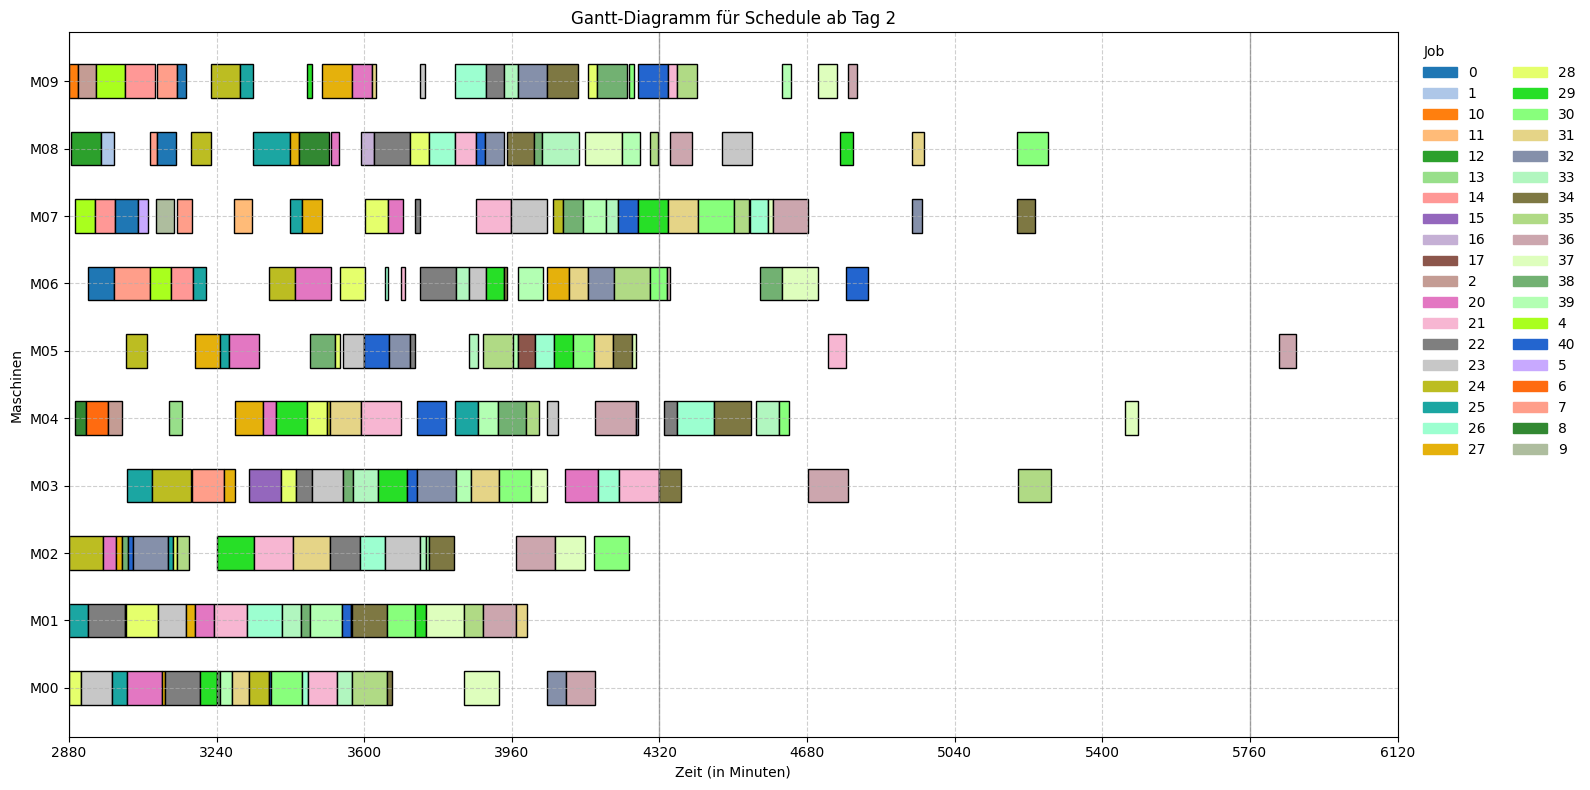

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           5
-240 - -180     1
-180 - -120     0
-120 - -60      1
-60 - 0         0
0              22
0 - 60          3
60 - 120        1
120 - 180       1
180 - 240       0
>240            4
Name: count, dtype: int64
[Day 2 00:00:00] Job 10 started on M09
[Day 2 00:00:00] Job 24 started on M02
[Day 2 00:00:00] Job 25 started on M01
[Day 2 00:00:00] Job 28 started on M00
[Day 2 00:05:00] Job 12 started on M08
[Day 2 00:14:00] Job 4 started on M07
[Day 2 00:15:00] Job 8 started on M04
[Day 2 00:17:10] Job 10 finished on M09 (after 17 minutes 11 seconds)
[Day 2 00:21:00] Job 2 started on M09
[Day 2 00:29:58] Job 28 finished on M00 (after 29 minutes 59 seconds)
[Day 2 00:29:58] Job 23 started on M00
[Day 2 00:43:27] Job 8 finish

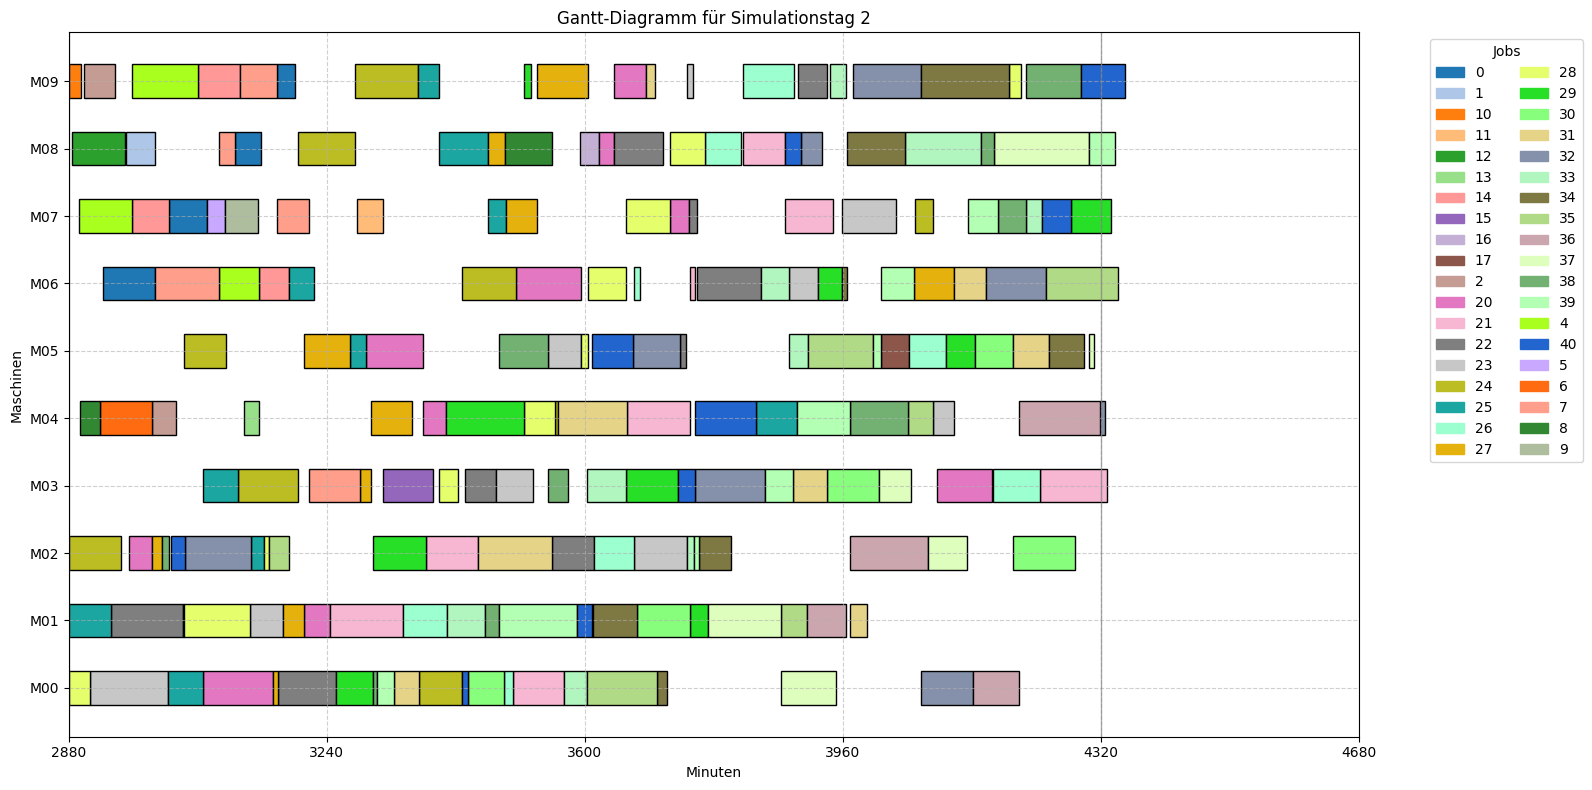

----------------------------------------------------------------------
Day 03: [4320, 5760)
[INFO] Anzahl Jobs mit Ready Time 4320: 17
[INFO] 36 zusätzliche Operationen hinzugefügt (gesamt: 206).
[INFO] 6 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 24518.00
Best Objective Bound  : 24518.00
Laufzeit              : 0.50 Sekunden
Deviation terms       : 36


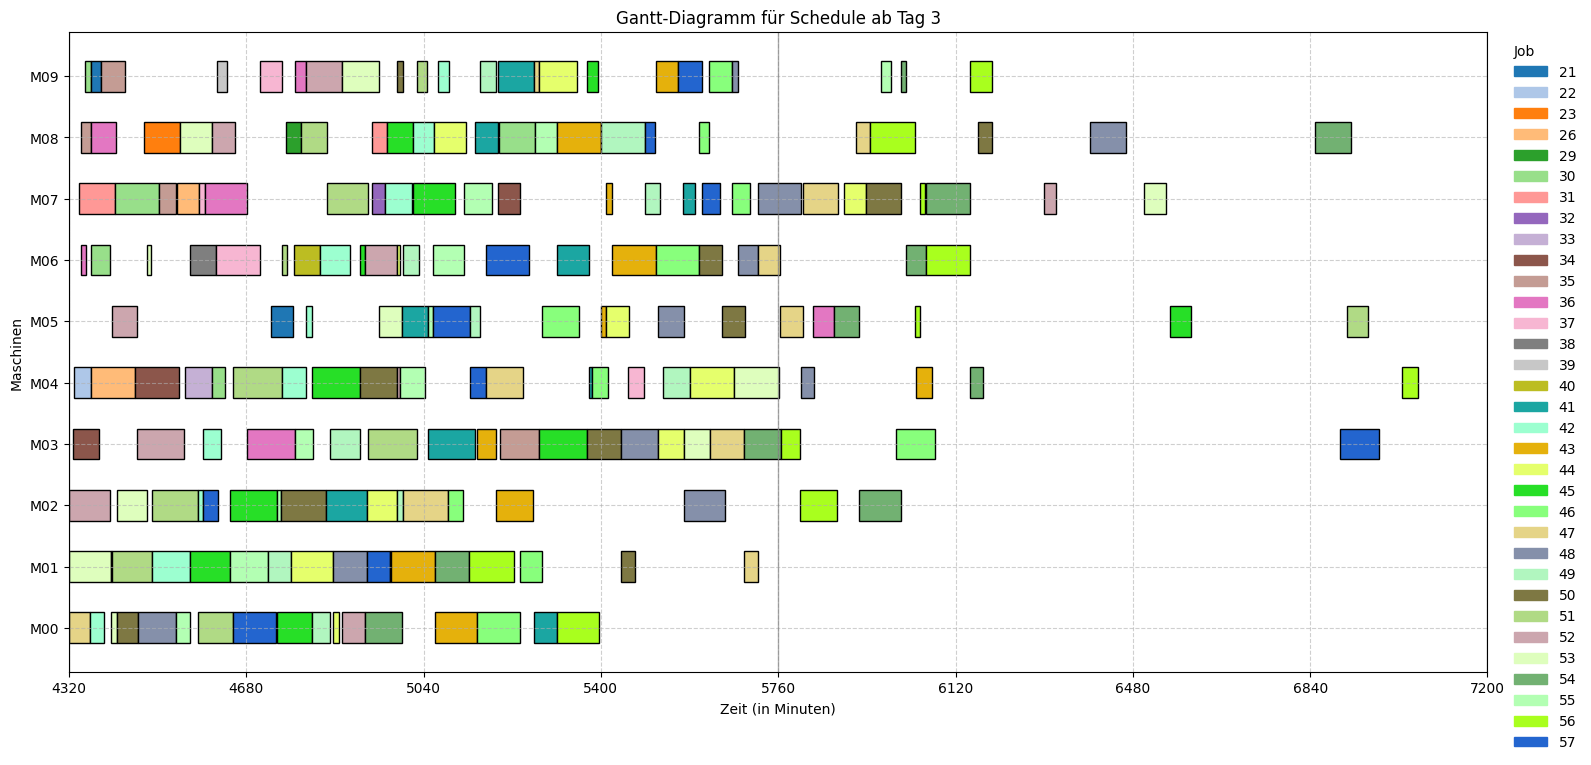

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              33
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 3 00:00:00] Job 47 started on M00
[Day 3 00:00:00] Job 52 started on M02
[Day 3 00:00:00] Job 53 started on M01
[Day 3 00:09:00] Job 34 started on M03
[Day 3 00:11:00] Job 22 started on M04
[Day 3 00:21:00] Job 31 started on M07
[Day 3 00:25:00] Job 35 started on M08
[Day 3 00:25:00] Job 36 started on M06
[Day 3 00:33:00] Job 30 started on M09
[Day 3 00:33:15] Job 36 finished on M06 (after 08 minutes 15 seconds)
[Day 3 00:37:18] Job 47 finished on M00 (after 37 minutes 18 seconds)
[Day 3 00:40:19] Job 22 fi

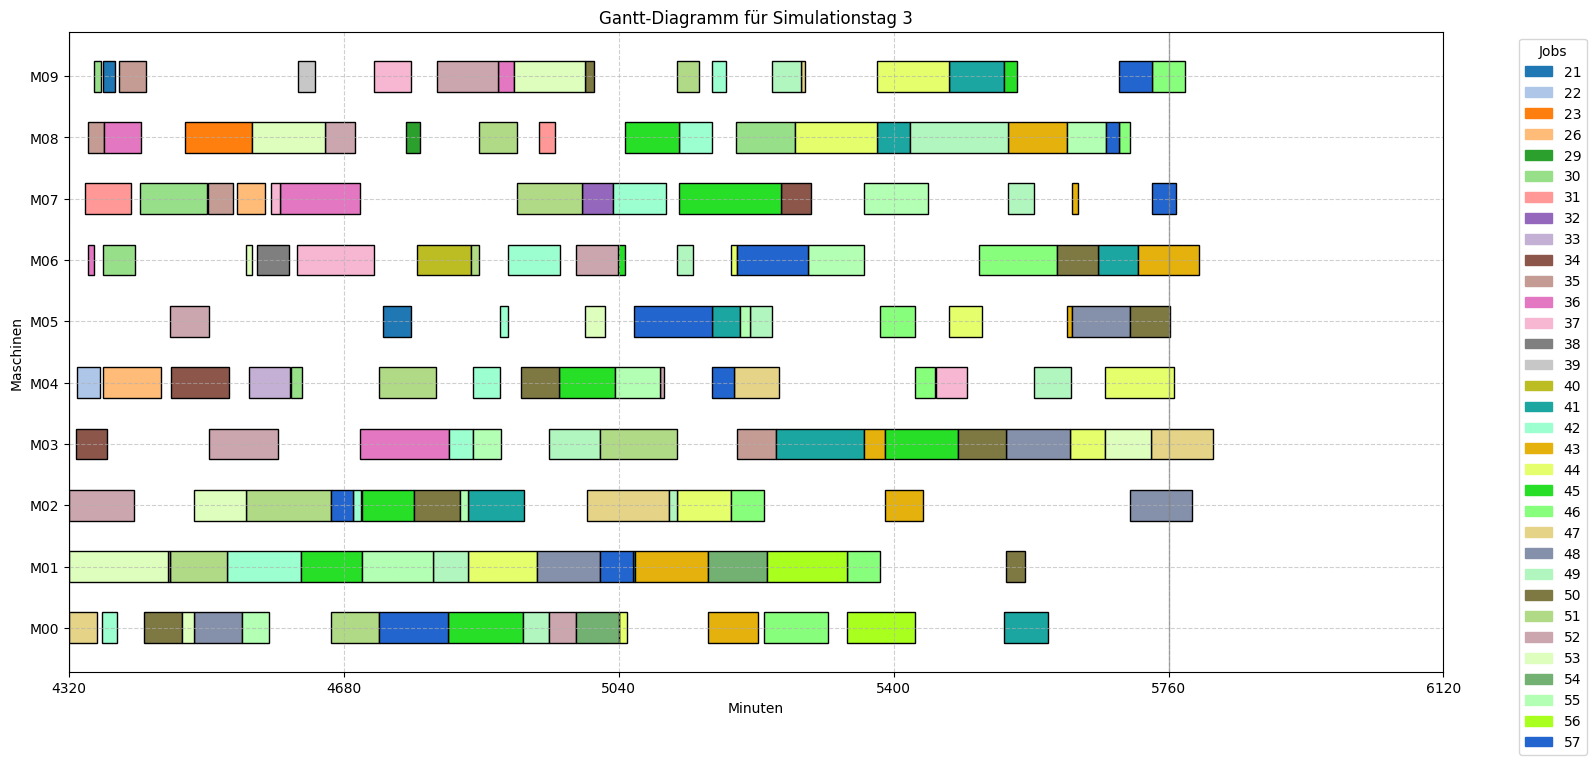

----------------------------------------------------------------------
Day 04: [5760, 7200)
[INFO] Anzahl Jobs mit Ready Time 5760: 17
[INFO] 43 zusätzliche Operationen hinzugefügt (gesamt: 213).
[INFO] 7 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 301488.00
Best Objective Bound  : 301488.00
Laufzeit              : 9.11 Sekunden
Deviation terms       : 43


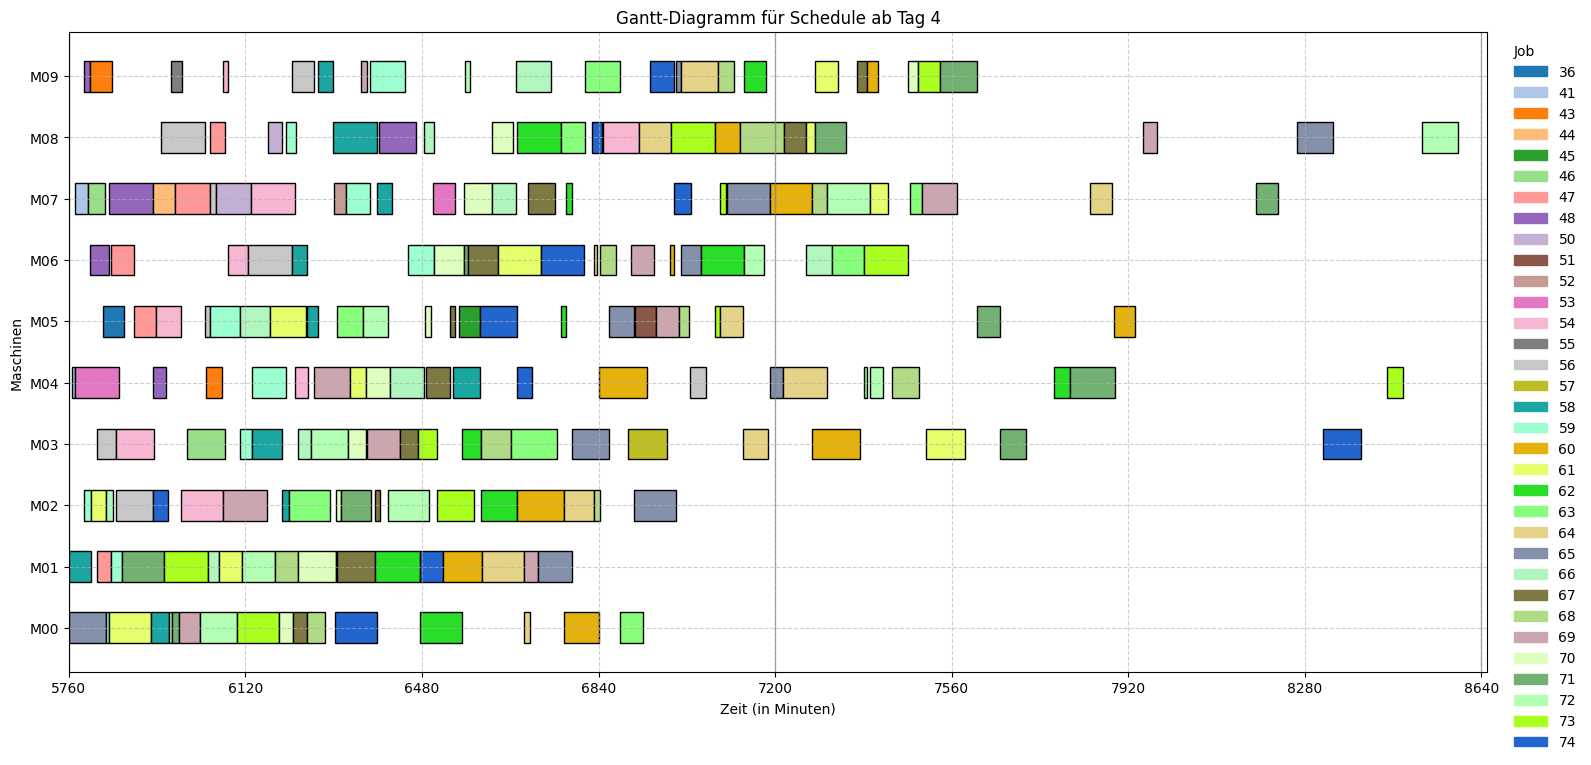

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              30
0 - 60          1
60 - 120        0
120 - 180       1
180 - 240       1
>240            0
Name: count, dtype: int64
[Day 4 00:00:00] Job 58 started on M01
[Day 4 00:00:00] Job 65 started on M00
[Day 4 00:07:00] Job 41 started on M04
[Day 4 00:11:31] Job 41 finished on M04 (after 04 minutes 31 seconds)
[Day 4 00:13:00] Job 53 started on M04
[Day 4 00:13:00] Job 41 started on M07
[Day 4 00:31:00] Job 48 started on M09
[Day 4 00:31:00] Job 59 started on M02
[Day 4 00:38:30] Job 41 finished on M07 (after 25 minutes 30 seconds)
[Day 4 00:38:30] Job 46 started on M07
[Day 4 00:41:18] Job 48 finished on M09 (after 10 minutes 19 seco

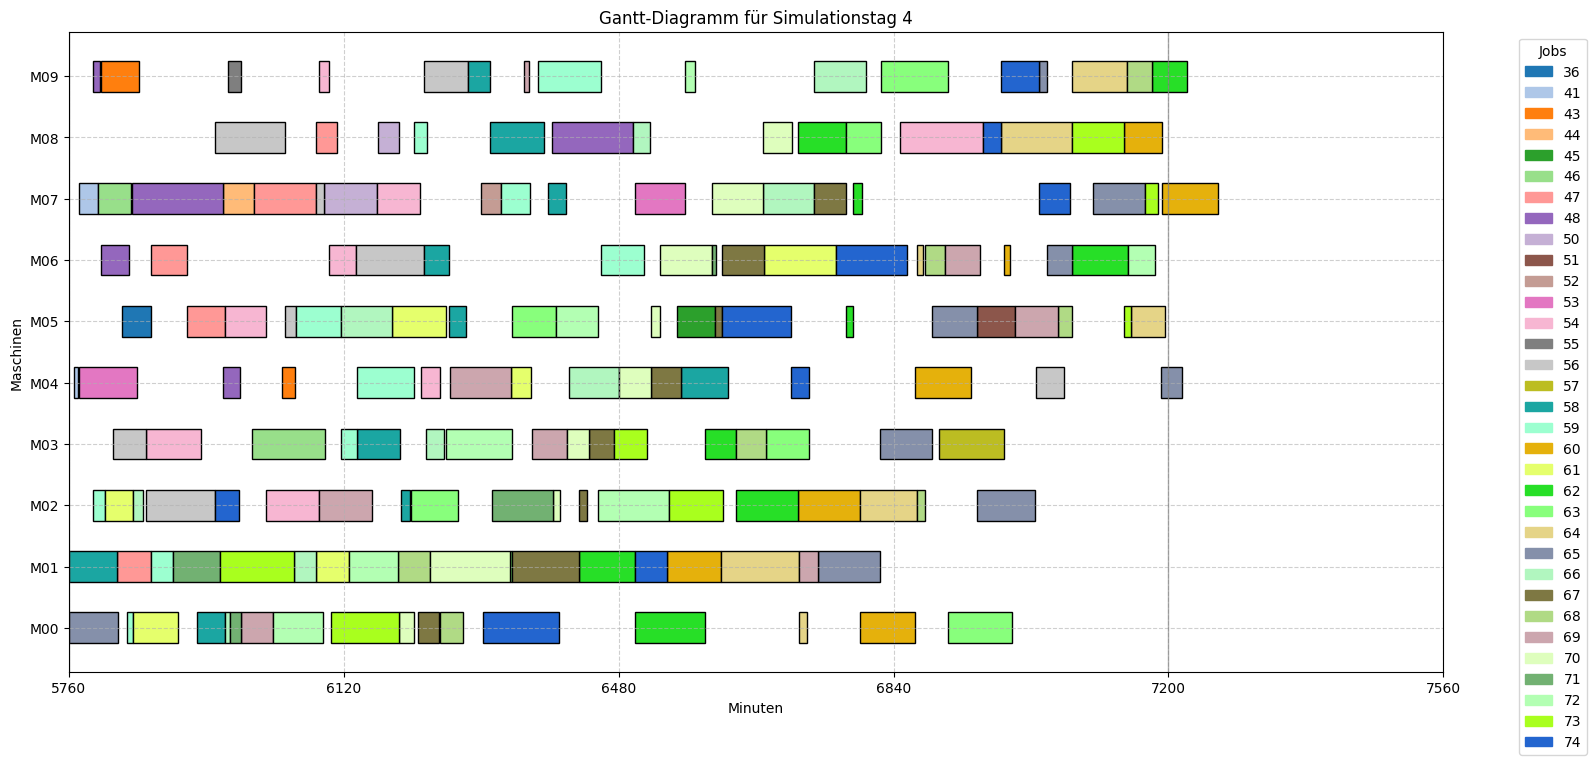

----------------------------------------------------------------------
Day 05: [7200, 8640)
[INFO] Anzahl Jobs mit Ready Time 7200: 21
[INFO] 37 zusätzliche Operationen hinzugefügt (gesamt: 247).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 36408.00
Best Objective Bound  : 36408.00
Laufzeit              : 7.89 Sekunden
Deviation terms       : 37


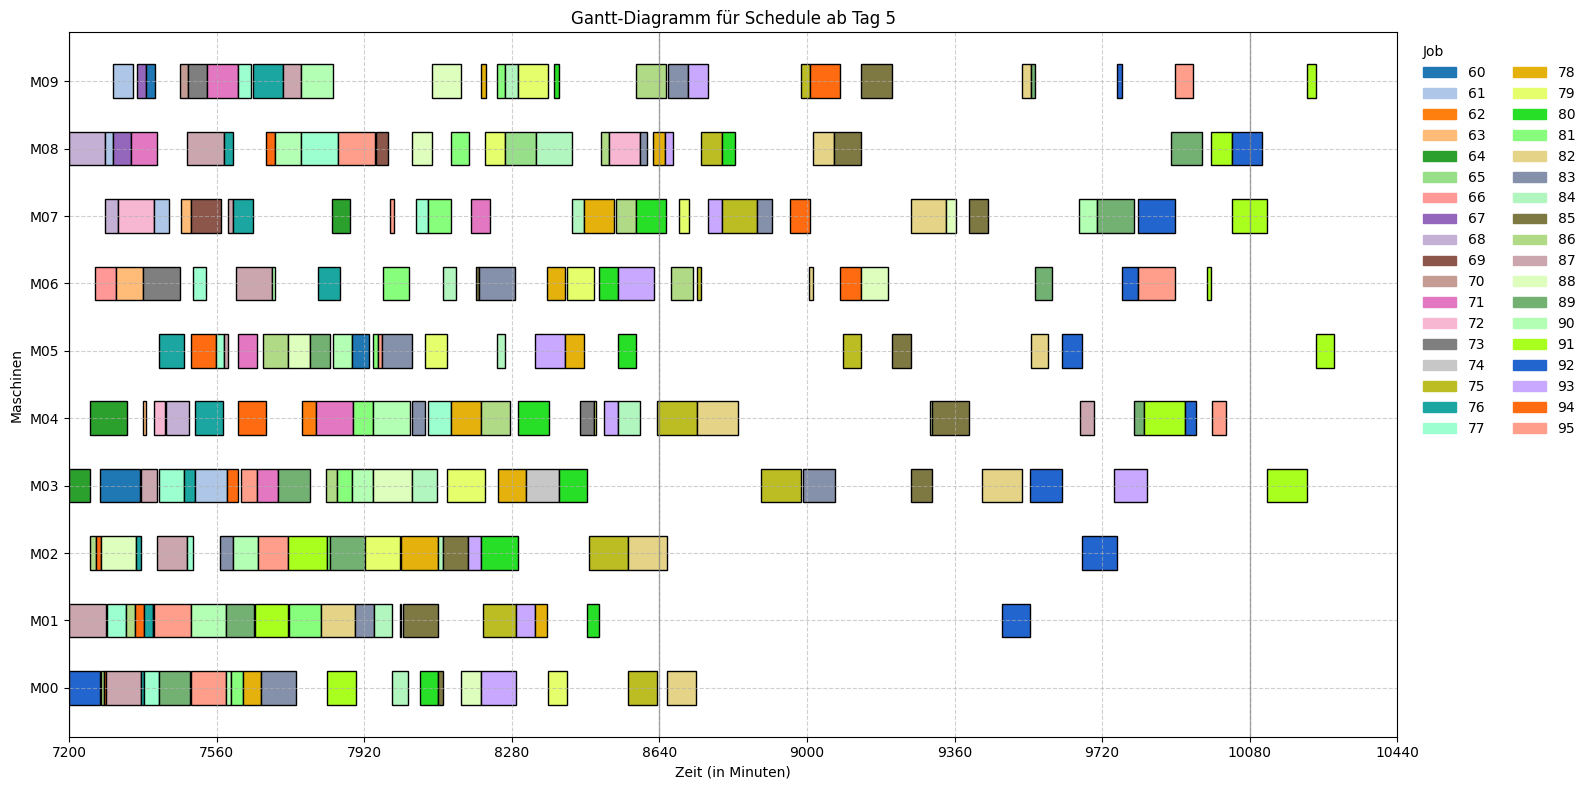

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              36
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 5 00:00:00] Job 64 started on M03
[Day 5 00:00:00] Job 68 started on M08
[Day 5 00:00:00] Job 87 started on M01
[Day 5 00:00:00] Job 92 started on M00
[Day 5 00:38:00] Job 64 finished on M03 (after 38 minutes)
[Day 5 00:51:00] Job 86 started on M02
[Day 5 00:52:00] Job 64 started on M04
[Day 5 01:03:00] Job 66 started on M06
[Day 5 01:08:17] Job 86 finished on M02 (after 17 minutes 17 seconds)
[Day 5 01:08:17] Job 94 started on M02
[Day 5 01:15:00] Job 60 started on M03
[Day 5 01:20:33] Job 92 finished on M

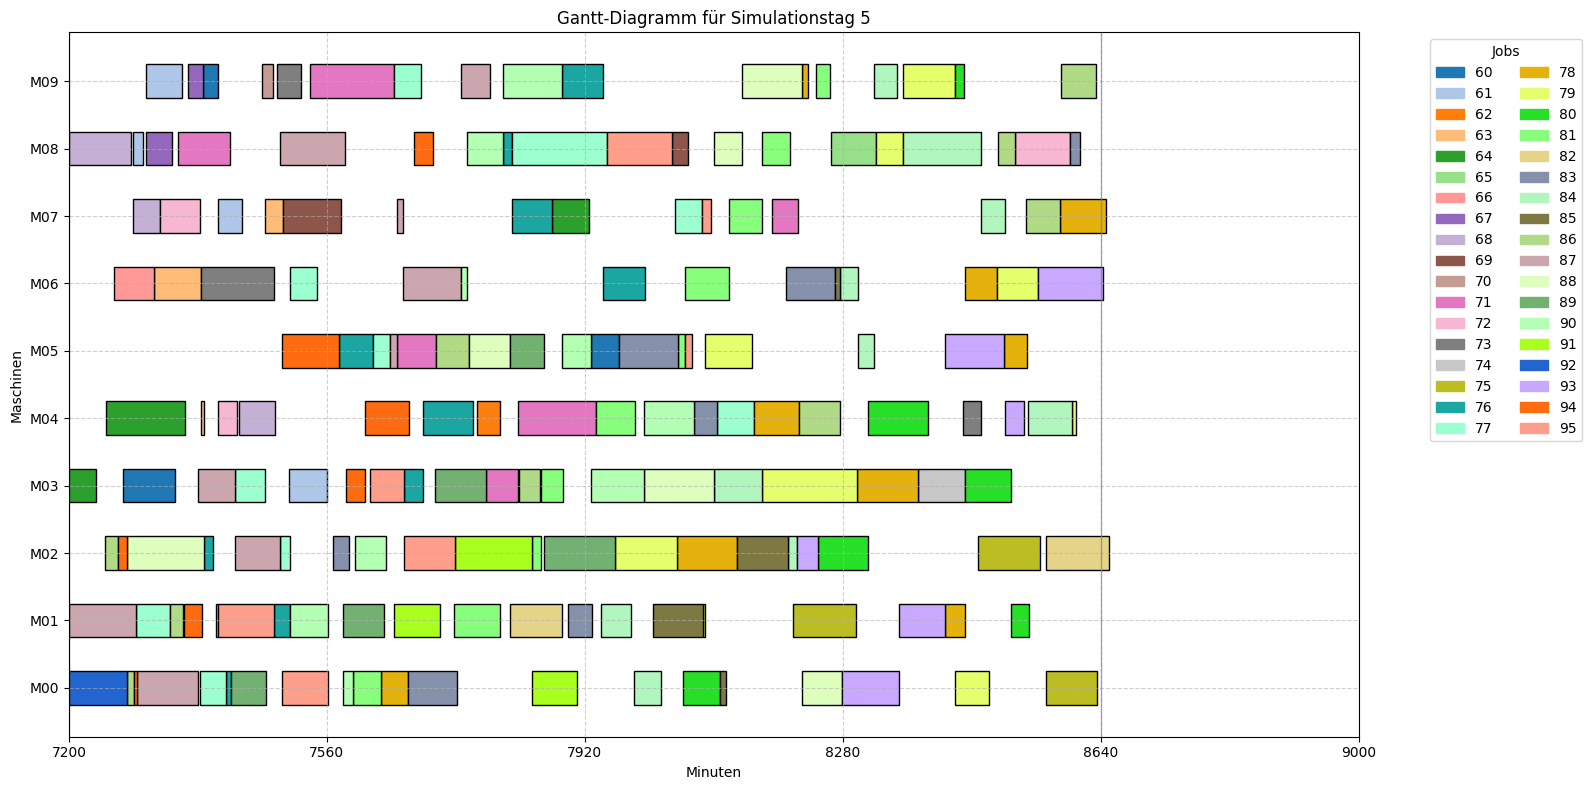

----------------------------------------------------------------------
Day 06: [8640, 10080)
[INFO] Anzahl Jobs mit Ready Time 8640: 29
[INFO] 67 zusätzliche Operationen hinzugefügt (gesamt: 357).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : FEASIBLE
Objective Value       : 97152.00
Best Objective Bound  : 80152.00
Laufzeit              : 2400.53 Sekunden
Deviation terms       : 67


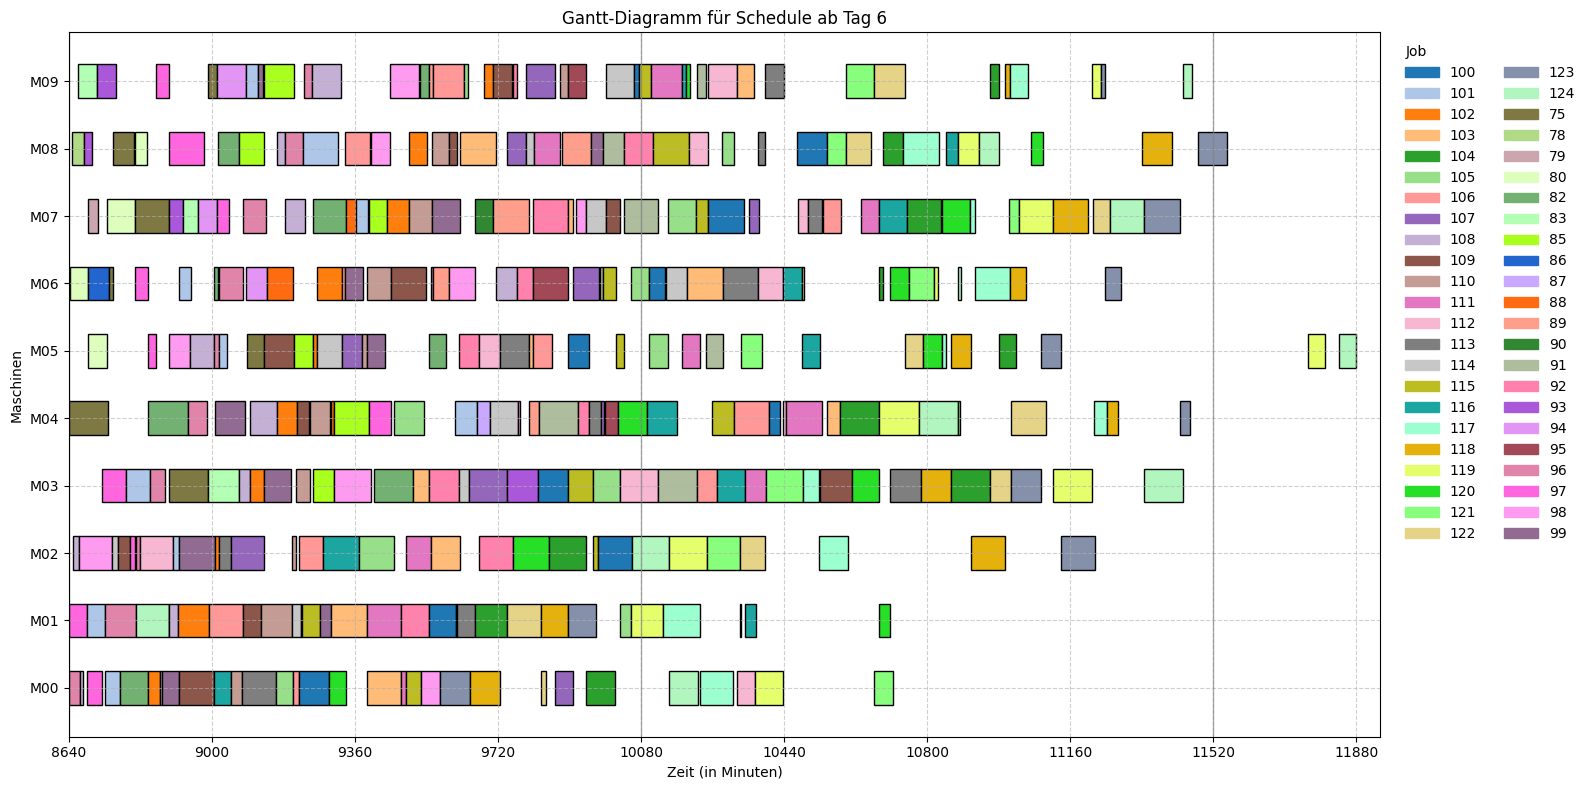

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      2
-60 - 0         5
0              34
0 - 60          5
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 6 00:00:00] Job 75 started on M04
[Day 6 00:00:00] Job 96 started on M00
[Day 6 00:00:00] Job 97 started on M01
[Day 6 00:03:00] Job 80 started on M06
[Day 6 00:08:00] Job 78 started on M08
[Day 6 00:11:00] Job 108 started on M02
[Day 6 00:22:00] Job 83 started on M09
[Day 6 00:26:28] Job 108 finished on M02 (after 15 minutes 29 seconds)
[Day 6 00:26:28] Job 98 started on M02
[Day 6 00:28:03] Job 96 finished on M00 (after 28 minutes 04 seconds)
[Day 6 00:29:00] Job 108 started on M00
[Day 6 00:35:54] Job 10

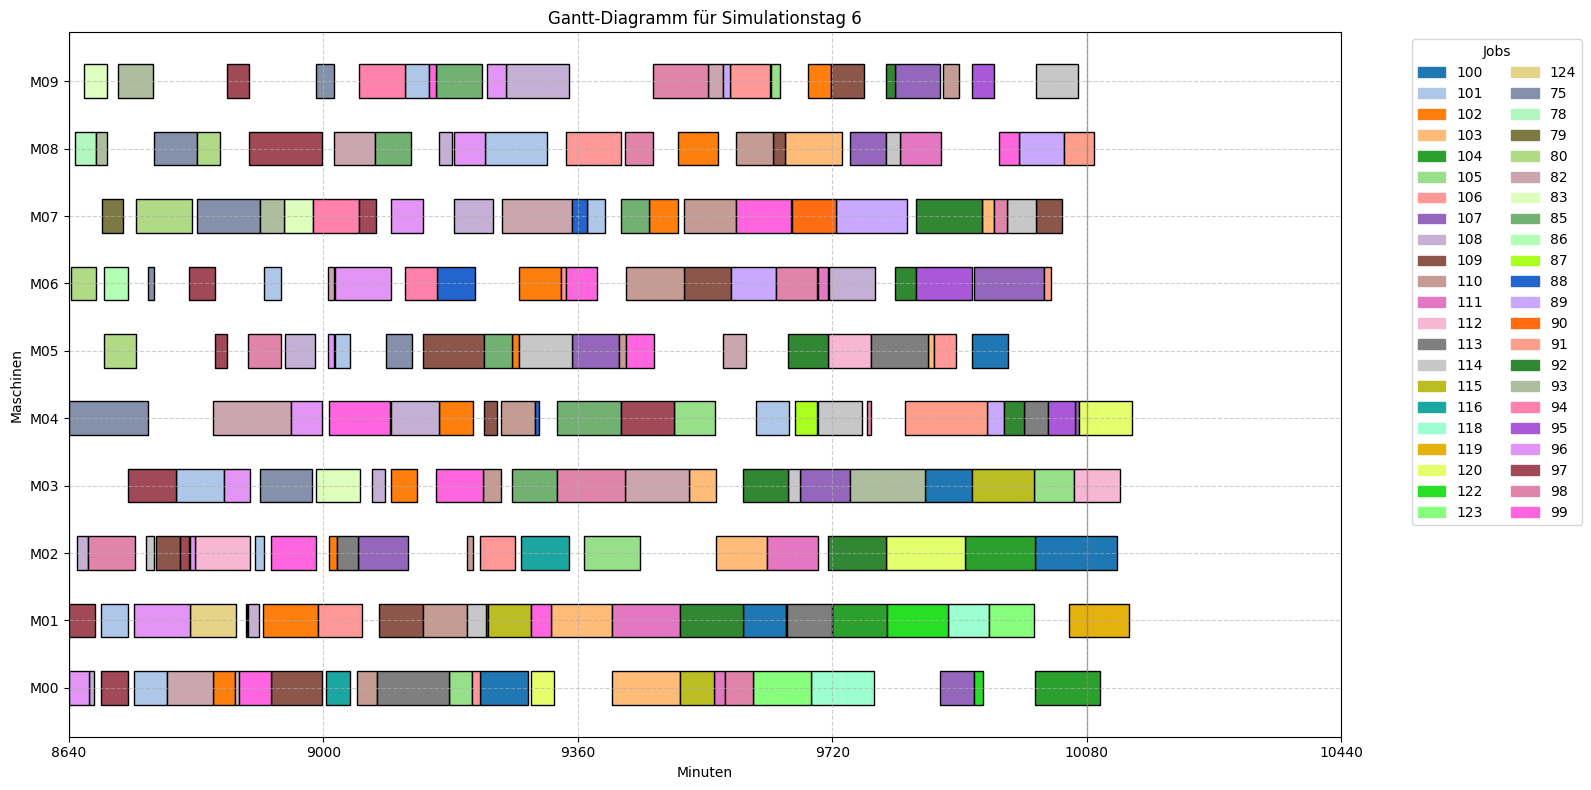

----------------------------------------------------------------------


In [13]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times_all, df_jssp_all, ready_time = day_start, verbose=True)

    
    # ---------- b) Zusammenführung mit unerledigten Operationen -------
    df_jssp_curr = process_filter.extend_with_undone_operations(df_jssp_curr, df_undone, verbose=True)
    df_times_curr = process_filter.update_times_after_operation_changes(df_job_times_all, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = process_filter.get_operations_running_into_day(df_execution, day_start, verbose=True)

    # ------------------------ III. Rescheduling --------------------------------
    #----------------------------------------------------------------------------

    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_times_curr, 
                                                                                       df_execution_important, 
                                                                                       df_original_plan = df_undone,
                                                                                       w_t = 5,
                                                                                       r = 0.18, # 18% Lateness, 82% Deviation
                                                                                       reschedule_start = day_start, 
                                                                                       msg=False, timeLimit=max_time, gapRel= 0.001)
    
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_schedule.to_csv(data_path / file, index=False)
    
    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")
    check.all_in_one(df_schedule)

    last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    # ------------------------ IV. Simulation -----------------------------------
    simulation = ProductionSimulation(df_schedule, sigma=0.2)
    df_execution = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}")
    else:
        print(f"Nothing executed on day {day_numb}")

    df_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
    print("-"*70)